# TRIAL BUILD


In [1]:
# Import initial libraries

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Imports in order to be able to use Plotly offline.
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objs as go

print(__version__) # requires version >= 1.9.0

init_notebook_mode(connected=True)

4.6.0


In [4]:
# Import the Sample worksheet with acquisition dates and initial cost basis:

portfolio_df = pd.read_excel(r'C:/Users/gordon/OneDrive/CODE/4_Data/1_FullBuilds/sample/Sample stocks acquisition dates_costs.xlsx')

portfolio_df.head(10)

,Acquisition Date,Ticker,Quantity,Unit Cost,Cost Basis,Start of Year
0,2013-02-07,AAPL,125,65.40,8175.00,2017-12-29
1,2014-02-27,JNJ,100,81.90,8190.00,2017-12-29
2,2013-06-04,MCD,100,84.99,8499.00,2017-12-29
3,2015-12-14,MTCH,600,13.63,8178.00,2017-12-29
4,2016-01-14,NFLX,75,108.71,8153.25,2017-12-29
5,2013-08-14,WMT,125,68.30,8537.50,2017-12-29
6,2013-12-13,FB,150,53.32,7998.00,2017-12-29
7,2015-01-05,TWTR,225,36.38,8185.50,2017-12-29


In [5]:
# Confirm that you have 8 values for each column.

portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Acquisition Date  8 non-null      datetime64[ns]
 1   Ticker            8 non-null      object        
 2   Quantity          8 non-null      int64         
 3   Unit Cost         8 non-null      float64       
 4   Cost Basis        8 non-null      float64       
 5   Start of Year     8 non-null      datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 512.0+ bytes


In [6]:
# Date Ranges for SP 500 and for all tickers
# Modify these date ranges each week.

# The below will pull back stock prices from 2010 until end date specified.
start_sp = datetime.datetime(2017, 1, 30)
end_sp = datetime.datetime(2020, 3, 30)

# This variable is used for YTD performance.
end_of_last_year = datetime.datetime(2019, 12, 30)

# These are separate if for some reason want different date range than SP.
stocks_start = datetime.datetime(2017, 1, 30)
stocks_end = datetime.datetime(2020, 3, 26)

In [7]:
# Leveraged from the helpful Datacamp Python Finance trading blog post.

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

sp500 = pdr.get_data_yahoo('^GSPC', 
                           start_sp,
                             end_sp)
                          
sp500.head()

C:\Users\gordon\AppData\Roaming\Python\Python37\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-30,2286.010010,2286.010010,2268.040039,2280.899902,2280.899902,3591270000
2017-01-31,2274.020020,2279.090088,2267.209961,2278.870117,2278.870117,4087450000
2017-02-01,2285.590088,2289.139893,2272.439941,2279.550049,2279.550049,3916610000
2017-02-02,2276.689941,2283.969971,2271.649902,2280.850098,2280.850098,3807710000
2017-02-03,2288.540039,2298.310059,2287.879883,2297.419922,2297.419922,3597970000


In [8]:
sp500.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-23,2290.709961,2300.729980,2191.860107,2237.399902,2237.399902,7402180000
2020-03-24,2344.439941,2449.709961,2344.439941,2447.330078,2447.330078,7547350000
2020-03-25,2457.770020,2571.419922,2407.530029,2475.560059,2475.560059,8285670000
2020-03-26,2501.290039,2637.010010,2500.719971,2630.070068,2630.070068,7753160000
2020-03-27,2555.870117,2615.909912,2520.020020,2541.469971,2541.469971,6194330000


In [9]:
# Create a dataframe with only the Adj Close column as that's all we need for this analysis.

sp_500_adj_close = sp500[['Adj Close']].reset_index()

In [10]:
sp_500_adj_close.tail()


,Date,Adj Close
791,2020-03-23,2237.399902
792,2020-03-24,2447.330078
793,2020-03-25,2475.560059
794,2020-03-26,2630.070068
795,2020-03-27,2541.469971


In [11]:
# Adj Close for the EOY in 2017 in order to run comparisons versus stocks YTD performances.

sp_500_adj_close_start = sp_500_adj_close[sp_500_adj_close['Date']==end_of_last_year]
sp_500_adj_close_start

,Date,Adj Close
734,2019-12-30,3221.290039


In [12]:
# Generate a dynamic list of tickers to pull from Yahoo Finance API based on the imported file with tickers.
tickers = portfolio_df['Ticker'].unique()
tickers

array(['AAPL', 'JNJ', 'MCD', 'MTCH', 'NFLX', 'WMT', 'FB', 'TWTR'],
      dtype=object)

In [13]:
# Stock comparison code

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map(data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))
               
all_data = get(tickers, stocks_start, stocks_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
all_data

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
AAPL   2017-01-30  120.930000  121.629997  120.660004  121.629997  115.913605   
       2017-01-31  121.150002  121.389999  120.620003  121.349998  115.646774   
       2017-02-01  127.029999  130.490005  127.010002  128.750000  122.698990   
       2017-02-02  127.980003  129.389999  127.779999  128.529999  122.489342   
       2017-02-03  128.309998  129.190002  128.160004  129.080002  123.013496   
...                       ...         ...         ...         ...         ...   
TWTR   2020-03-19   22.110001   25.170000   20.660000   24.129999   24.129999   
       2020-03-20   24.969999   25.860001   23.700001   23.950001   23.950001   
       2020-03-23   23.799999   25.250000   23.500000   24.690001   24.690001   
       2020-03-24   25.790001   26.459999   24.129999   25.850000   25.850000   
       2020-03-25   25.850000   27.459999   24.520000   25.969999   25.969999   

                      Volume  
Ticker Date                   
AAPL   2017-01-30   30377500  
       2017-01-31   49201000  
       2017-02-01  111985000  
       2017-02-02   33710400  
       2017-02-03   24507300  
...                      ...  
TWTR   2020-03-19   29980000  
       2020-03-20   28250700  
       2020-03-23   21882600  
       2020-03-24   32815900  
       2020-03-25   25738800  

[6352 rows x 6 columns]

In [15]:
# Also only pulling the ticker, date and adj. close columns for our tickers.

adj_close = all_data[['Adj Close']].reset_index()
adj_close

,Ticker,Date,Adj Close
0,AAPL,2017-01-30,115.913605
1,AAPL,2017-01-31,115.646774
2,AAPL,2017-02-01,122.698990
3,AAPL,2017-02-02,122.489342
4,AAPL,2017-02-03,123.013496
...,...,...,...
6347,TWTR,2020-03-19,24.129999
6348,TWTR,2020-03-20,23.950001
6349,TWTR,2020-03-23,24.690001
6350,TWTR,2020-03-24,25.850000


In [16]:
# Grabbing the ticker close from the end of last year
adj_close_start = adj_close[adj_close['Date']==end_of_last_year]
adj_close_start.head()

,Ticker,Date,Adj Close
734,AAPL,2019-12-30,290.829773
1528,JNJ,2019-12-30,144.379349
2322,MCD,2019-12-30,195.685440
3116,MTCH,2019-12-30,82.980003
3910,NFLX,2019-12-30,323.309998


In [17]:
# Grab the latest stock close price

adj_close_latest = adj_close[adj_close['Date']==stocks_end]
adj_close_latest

,Ticker,Date,Adj Close


In [18]:
adj_close_latest.set_index('Ticker', inplace=True)
adj_close_latest.head()

,Date,Adj Close
Ticker,,


In [19]:
portfolio_df.set_index(['Ticker'], inplace=True)
portfolio_df.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
Ticker,,,,,
AAPL,2013-02-07,125,65.40,8175.00,2017-12-29
JNJ,2014-02-27,100,81.90,8190.00,2017-12-29
MCD,2013-06-04,100,84.99,8499.00,2017-12-29
MTCH,2015-12-14,600,13.63,8178.00,2017-12-29
NFLX,2016-01-14,75,108.71,8153.25,2017-12-29


In [20]:
# Merge the portfolio dataframe with the adj close dataframe; they are being joined by their indexes.

merged_portfolio = pd.merge(portfolio_df, adj_close_latest, left_index=True, right_index=True)
merged_portfolio.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Date,Adj Close
Ticker,,,,,,,


In [21]:
# The below creates a new column which is the ticker return; takes the latest adjusted close for each position
# and divides that by the initial share cost.

merged_portfolio['ticker return'] = merged_portfolio['Adj Close'] / merged_portfolio['Unit Cost'] - 1

#merged_portfolio

In [22]:
merged_portfolio.reset_index(inplace=True)

In [23]:
# Here we are merging the new dataframe with the sp500 adjusted closes since the sp start price based on 
# each ticker's acquisition date and sp500 close date.

merged_portfolio_sp = pd.merge(merged_portfolio, sp_500_adj_close, left_on='Acquisition Date', right_on='Date')
# .set_index('Ticker')

#merged_portfolio_sp.head()

In [24]:
# We will delete the additional date column which is created from this merge.
# We then rename columns to Latest Date and then reflect Ticker Adj Close and SP 500 Initial Close.

del merged_portfolio_sp['Date_y']

merged_portfolio_sp.rename(columns={'Date_x': 'Latest Date', 'Adj Close_x': 'Ticker Adj Close'
                                    , 'Adj Close_y': 'SP 500 Initial Close'}, inplace=True)

#merged_portfolio_sp.head()

In [25]:
# This new column determines what SP 500 equivalent purchase would have been at purchase date of stock.
merged_portfolio_sp['Equiv SP Shares'] = merged_portfolio_sp['Cost Basis'] / merged_portfolio_sp['SP 500 Initial Close']
#merged_portfolio_sp.head()

In [26]:
# We are joining the developing dataframe with the sp500 closes again, this time with the latest close for SP.
merged_portfolio_sp_latest = pd.merge(merged_portfolio_sp, sp_500_adj_close, left_on='Latest Date', right_on='Date')

#merged_portfolio_sp_latest.head()

In [27]:
# Once again need to delete the new Date column added as it's redundant to Latest Date.  
# Modify Adj Close from the sp dataframe to distinguish it by calling it the SP 500 Latest Close.

del merged_portfolio_sp_latest['Date']

merged_portfolio_sp_latest.rename(columns={'Adj Close': 'SP 500 Latest Close'}, inplace=True)

#merged_portfolio_sp_latest.head()

In [28]:
# Percent return of SP from acquisition date of position through latest trading day.
merged_portfolio_sp_latest['SP Return'] = merged_portfolio_sp_latest['SP 500 Latest Close'] / merged_portfolio_sp_latest['SP 500 Initial Close'] - 1

# This is a new column which takes the tickers return and subtracts the sp 500 equivalent range return.
merged_portfolio_sp_latest['Abs. Return Compare'] = merged_portfolio_sp_latest['ticker return'] - merged_portfolio_sp_latest['SP Return']

# This is a new column where we calculate the ticker's share value by multiplying the original quantity by the latest close.
merged_portfolio_sp_latest['Ticker Share Value'] = merged_portfolio_sp_latest['Quantity'] * merged_portfolio_sp_latest['Ticker Adj Close']

# We calculate the equivalent SP 500 Value if we take the original SP shares * the latest SP 500 share price.
merged_portfolio_sp_latest['SP 500 Value'] = merged_portfolio_sp_latest['Equiv SP Shares'] * merged_portfolio_sp_latest['SP 500 Latest Close']

# This is a new column where we take the current market value for the shares and subtract the SP 500 value.
merged_portfolio_sp_latest['Abs Value Compare'] = merged_portfolio_sp_latest['Ticker Share Value'] - merged_portfolio_sp_latest['SP 500 Value']

# This column calculates profit / loss for stock position.
merged_portfolio_sp_latest['Stock Gain / (Loss)'] = merged_portfolio_sp_latest['Ticker Share Value'] - merged_portfolio_sp_latest['Cost Basis']

# This column calculates profit / loss for SP 500.
merged_portfolio_sp_latest['SP 500 Gain / (Loss)'] = merged_portfolio_sp_latest['SP 500 Value'] - merged_portfolio_sp_latest['Cost Basis']

#merged_portfolio_sp_latest.head()

In [29]:
# Merge the overall dataframe with the adj close start of year dataframe for YTD tracking of tickers.
# Should not need to do the outer join;

merged_portfolio_sp_latest_YTD = pd.merge(merged_portfolio_sp_latest, adj_close_start, on='Ticker')
# , how='outer'

#merged_portfolio_sp_latest_YTD.head()

In [30]:
# Deleting date again as it's an unnecessary column.  Explaining that new column is the Ticker Start of Year Close.

del merged_portfolio_sp_latest_YTD['Date']

merged_portfolio_sp_latest_YTD.rename(columns={'Adj Close': 'Ticker Start Year Close'}, inplace=True)

#merged_portfolio_sp_latest_YTD.head()

In [31]:
# Join the SP 500 start of year with current dataframe for SP 500 ytd comparisons to tickers.

merged_portfolio_sp_latest_YTD_sp = pd.merge(merged_portfolio_sp_latest_YTD, sp_500_adj_close_start
                                             , left_on='Start of Year', right_on='Date')

#merged_portfolio_sp_latest_YTD_sp.head()

In [32]:
# Deleting another unneeded Date column.

del merged_portfolio_sp_latest_YTD_sp['Date']

# Renaming so that it's clear this column is SP 500 start of year close.
merged_portfolio_sp_latest_YTD_sp.rename(columns={'Adj Close': 'SP Start Year Close'}, inplace=True)

# YTD return for portfolio position.
merged_portfolio_sp_latest_YTD_sp['Share YTD'] = merged_portfolio_sp_latest_YTD_sp['Ticker Adj Close'] / merged_portfolio_sp_latest_YTD_sp['Ticker Start Year Close'] - 1

# YTD return for SP to run compares.
merged_portfolio_sp_latest_YTD_sp['SP 500 YTD'] = merged_portfolio_sp_latest_YTD_sp['SP 500 Latest Close'] / merged_portfolio_sp_latest_YTD_sp['SP Start Year Close'] - 1

#merged_portfolio_sp_latest_YTD_sp.head()

In [33]:
merged_portfolio_sp_latest_YTD_sp = merged_portfolio_sp_latest_YTD_sp.sort_values(by='Ticker', ascending=True)
#merged_portfolio_sp_latest_YTD_sp

In [34]:
# Cumulative sum of original investment
merged_portfolio_sp_latest_YTD_sp['Cum Invst'] = merged_portfolio_sp_latest_YTD_sp['Cost Basis'].cumsum()

# Cumulative sum of Ticker Share Value (latest FMV based on initial quantity purchased).
merged_portfolio_sp_latest_YTD_sp['Cum Ticker Returns'] = merged_portfolio_sp_latest_YTD_sp['Ticker Share Value'].cumsum()

# Cumulative sum of SP Share Value (latest FMV driven off of initial SP equiv purchase).
merged_portfolio_sp_latest_YTD_sp['Cum SP Returns'] = merged_portfolio_sp_latest_YTD_sp['SP 500 Value'].cumsum()

# Cumulative CoC multiple return for stock investments
merged_portfolio_sp_latest_YTD_sp['Cum Ticker ROI Mult'] = merged_portfolio_sp_latest_YTD_sp['Cum Ticker Returns'] / merged_portfolio_sp_latest_YTD_sp['Cum Invst']

merged_portfolio_sp_latest_YTD_sp.head()

,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year,Latest Date,Ticker Adj Close,ticker return,SP 500 Initial Close,Equiv SP Shares,...,SP 500 Gain / (Loss),Ticker,Ticker Start Year Close,SP Start Year Close,Share YTD,SP 500 YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult


## Assessing Where Positions are At versus Highest Close

In [35]:
# Referencing the adj_close dataframe from above

adj_close.head()

,Ticker,Date,Adj Close
0,AAPL,2017-01-30,115.913605
1,AAPL,2017-01-31,115.646774
2,AAPL,2017-02-01,122.698990
3,AAPL,2017-02-02,122.489342
4,AAPL,2017-02-03,123.013496


In [36]:
portfolio_df.head()


,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
Ticker,,,,,
AAPL,2013-02-07,125,65.40,8175.00,2017-12-29
JNJ,2014-02-27,100,81.90,8190.00,2017-12-29
MCD,2013-06-04,100,84.99,8499.00,2017-12-29
MTCH,2015-12-14,600,13.63,8178.00,2017-12-29
NFLX,2016-01-14,75,108.71,8153.25,2017-12-29


In [37]:
# Need to factor in that some positions were purchased much more recently than others.
# Join adj_close dataframe with portfolio in order to have acquisition date.

portfolio_df.reset_index(inplace=True)

adj_close_acq_date = pd.merge(adj_close, portfolio_df, on='Ticker')

adj_close_acq_date.head()

,Ticker,Date,Adj Close,Acquisition Date,Quantity,Unit Cost,Cost Basis,Start of Year
0,AAPL,2017-01-30,115.913605,2013-02-07,125,65.4,8175.0,2017-12-29
1,AAPL,2017-01-31,115.646774,2013-02-07,125,65.4,8175.0,2017-12-29
2,AAPL,2017-02-01,122.698990,2013-02-07,125,65.4,8175.0,2017-12-29
3,AAPL,2017-02-02,122.489342,2013-02-07,125,65.4,8175.0,2017-12-29
4,AAPL,2017-02-03,123.013496,2013-02-07,125,65.4,8175.0,2017-12-29


In [38]:
# delete_columns = ['Quantity', 'Unit Cost', 'Cost Basis', 'Start of Year']

del adj_close_acq_date['Quantity']
del adj_close_acq_date['Unit Cost']
del adj_close_acq_date['Cost Basis']
del adj_close_acq_date['Start of Year']

# Sort by these columns in this order in order to make it clearer where compare for each position should begin.
adj_close_acq_date.sort_values(by=['Ticker', 'Acquisition Date', 'Date'], ascending=[True, True, True], inplace=True)

In [39]:
# Anything less than 0 means that the stock close was prior to acquisition.
adj_close_acq_date['Date Delta'] = adj_close_acq_date['Date'] - adj_close_acq_date['Acquisition Date']

adj_close_acq_date['Date Delta'] = adj_close_acq_date[['Date Delta']].apply(pd.to_numeric)  

adj_close_acq_date.head()

,Ticker,Date,Adj Close,Acquisition Date,Date Delta
0,AAPL,2017-01-30,115.913605,2013-02-07,125539200000000000
1,AAPL,2017-01-31,115.646774,2013-02-07,125625600000000000
2,AAPL,2017-02-01,122.698990,2013-02-07,125712000000000000
3,AAPL,2017-02-02,122.489342,2013-02-07,125798400000000000
4,AAPL,2017-02-03,123.013496,2013-02-07,125884800000000000


In [40]:
# Modified the dataframe being evaluated to look at highest close which occurred after Acquisition Date (aka, not prior to purchase).

adj_close_acq_date_modified = adj_close_acq_date[adj_close_acq_date['Date Delta']>=0]

adj_close_acq_date_modified.head()

,Ticker,Date,Adj Close,Acquisition Date,Date Delta
0,AAPL,2017-01-30,115.913605,2013-02-07,125539200000000000
1,AAPL,2017-01-31,115.646774,2013-02-07,125625600000000000
2,AAPL,2017-02-01,122.698990,2013-02-07,125712000000000000
3,AAPL,2017-02-02,122.489342,2013-02-07,125798400000000000
4,AAPL,2017-02-03,123.013496,2013-02-07,125884800000000000


In [41]:
# This pivot table will index on the Ticker and Acquisition Date, and find the max adjusted close.

adj_close_pivot = adj_close_acq_date_modified.pivot_table(index=['Ticker', 'Acquisition Date'], values='Adj Close', aggfunc=np.max)

adj_close_pivot.reset_index(inplace=True)

adj_close_pivot

,Ticker,Acquisition Date,Adj Close
0,AAPL,2013-02-07,327.200012
1,FB,2013-12-13,223.229996
2,JNJ,2014-02-27,153.014282
3,MCD,2013-06-04,217.269257
4,MTCH,2015-12-14,92.449997
5,NFLX,2016-01-14,418.970001
6,TWTR,2015-01-05,46.759998
7,WMT,2013-08-14,122.040009


In [42]:
# Merge the adj close pivot table with the adj_close table in order to grab the date of the Adj Close High (good to know).

adj_close_pivot_merged = pd.merge(adj_close_pivot, adj_close
                                             , on=['Ticker', 'Adj Close'])

adj_close_pivot_merged.head()

,Ticker,Acquisition Date,Adj Close,Date
0,AAPL,2013-02-07,327.200012,2020-02-12
1,FB,2013-12-13,223.229996,2020-01-29
2,JNJ,2014-02-27,153.014282,2020-02-05
3,MCD,2013-06-04,217.269257,2019-09-06
4,MTCH,2015-12-14,92.449997,2020-01-16


In [43]:
# Merge the Adj Close pivot table with the master dataframe to have the closing high since you have owned the stock.

merged_portfolio_sp_latest_YTD_sp_closing_high = pd.merge(merged_portfolio_sp_latest_YTD_sp, adj_close_pivot_merged
                                             , on=['Ticker', 'Acquisition Date'])

# Renaming so that it's clear that the new columns are two year closing high and two year closing high date.
merged_portfolio_sp_latest_YTD_sp_closing_high.rename(columns={'Adj Close': 'Closing High Adj Close', 'Date': 'Closing High Adj Close Date'}, inplace=True)

merged_portfolio_sp_latest_YTD_sp_closing_high['Pct off High'] = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker Adj Close'] / merged_portfolio_sp_latest_YTD_sp_closing_high['Closing High Adj Close'] - 1 

merged_portfolio_sp_latest_YTD_sp_closing_high

,Quantity,Unit Cost,Cost Basis,Start of Year,Latest Date,Ticker Adj Close,ticker return,SP 500 Initial Close,Equiv SP Shares,SP 500 Latest Close,...,SP 500 YTD,Cum Invst,Cum Ticker Returns,Cum SP Returns,Cum Ticker ROI Mult,Ticker,Acquisition Date,Closing High Adj Close,Closing High Adj Close Date,Pct off High


In [44]:
# Not needed for this blog post -- this is if you have multiple positions for the same ticker with different acquisition dates.
# merged_portfolio_sp_latest_YTD_sp_closing_high['Counts'] = merged_portfolio_sp_latest_YTD_sp_closing_high.index

# merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker #'] = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'].map(str) + ' ' + merged_portfolio_sp_latest_YTD_sp_closing_high['Counts'].map(str)

# merged_portfolio_sp_latest_YTD_sp_closing_high.head()

## YTD and Trailing Stop Charts

In [45]:
# Ploty is an outstanding resource for interactive charts.

trace1 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp['Share YTD'][0:10],
    name = 'Ticker YTD')

trace2 = go.Scatter(
    x = merged_portfolio_sp_latest_YTD_sp['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp['SP 500 YTD'][0:10],
    name = 'SP500 YTD')
    
data = [trace1, trace2]

layout = go.Layout(title = 'YTD Return vs S&P 500 YTD'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.8,y=1)
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [46]:
# Current Share Price versus Closing High Since Purchased

trace1 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Pct off High'][0:10],
    name = 'Pct off High')
    
data = [trace1]

layout = go.Layout(title = 'Adj Close % off of High'
    , barmode = 'group'
    , yaxis=dict(title='% Below Adj Close High', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.8,y=1)
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Total Return Comparison Charts

In [47]:
trace1 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['ticker return'][0:10],
    name = 'Ticker Total Return')

trace2 = go.Scatter(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['SP Return'][0:10],
    name = 'SP500 Total Return')
    
data = [trace1, trace2]

layout = go.Layout(title = 'Total Return vs S&P 500'
    , barmode = 'group'
    , yaxis=dict(title='Returns', tickformat=".2%")
    , xaxis=dict(title='Ticker', tickformat=".2%")
    , legend=dict(x=.8,y=1)
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## Cumulative Returns Over Time

In [48]:
trace1 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Stock Gain / (Loss)'][0:10],
    name = 'Ticker Total Return ($)')

trace2 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['SP 500 Gain / (Loss)'][0:10],
    name = 'SP 500 Total Return ($)')

trace3 = go.Scatter(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'][0:10],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['ticker return'][0:10],
    name = 'Ticker Total Return %',
    yaxis='y2')

data = [trace1, trace2, trace3]

layout = go.Layout(title = 'Gain / (Loss) Total Return vs S&P 500'
    , barmode = 'group'
    , yaxis=dict(title='Gain / (Loss) ($)')
    , yaxis2=dict(title='Ticker Return', overlaying='y', side='right', tickformat=".2%")
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.75,y=1)
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [49]:
trace1 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Cum Invst'],
    # mode = 'lines+markers',
    name = 'Cum Invst')

trace2 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Cum SP Returns'],
    # mode = 'lines+markers',
    name = 'Cum SP500 Returns')

trace3 = go.Bar(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Cum Ticker Returns'],
    # mode = 'lines+markers',
    name = 'Cum Ticker Returns')

trace4 = go.Scatter(
    x = merged_portfolio_sp_latest_YTD_sp_closing_high['Ticker'],
    y = merged_portfolio_sp_latest_YTD_sp_closing_high['Cum Ticker ROI Mult'],
    # mode = 'lines+markers',
    name = 'Cum ROI Mult'
    , yaxis='y2')


data = [trace1, trace2, trace3, trace4]

layout = go.Layout(title = 'Total Cumulative Investments Over Time'
    , barmode = 'group'
    , yaxis=dict(title='Returns')
    , xaxis=dict(title='Ticker')
    , legend=dict(x=.4,y=1)
    , yaxis2=dict(title='Cum ROI Mult', overlaying='y', side='right')               
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# finance test

In [50]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [51]:
from pandas_datareader import data as pdr
import yfinance as yf

aapl = pdr.get_data_yahoo('AAPL', 
                          start=datetime.datetime(2006, 10, 1), 
                          end=datetime.datetime(2012, 1, 1))
aapl.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,10.728572,10.838572,10.614285,10.694285,9.283074,178159800
2006-10-03,10.635715,10.707143,10.455714,10.582857,9.186352,197677200
2006-10-04,10.585714,10.780000,10.451428,10.768572,9.347562,207270700
2006-10-05,10.647142,10.880000,10.590000,10.690000,9.279355,170970800
2006-10-06,10.631429,10.720000,10.544286,10.602858,9.203714,116739700


In [52]:

import quandl 
aapl = quandl.get("WIKI/AAPL", start_date="2006-10-01", end_date="2012-01-01")
aapl.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2006-10-02,75.10,75.870,74.30,74.86,25451400.0,0.0,1.0,9.651397,9.750352,9.548586,9.620553,178159800.0
2006-10-03,74.45,74.950,73.19,74.07,28239600.0,0.0,1.0,9.567863,9.632120,9.405935,9.519027,197677200.0
2006-10-04,74.10,75.462,73.16,75.38,29610100.0,0.0,1.0,9.522883,9.697919,9.402080,9.687381,207270700.0
2006-10-05,74.53,76.160,74.13,74.83,24424400.0,0.0,1.0,9.578144,9.787621,9.526738,9.616698,170970800.0
2006-10-06,74.42,75.040,73.81,74.22,16677100.0,0.0,1.0,9.564007,9.643686,9.485614,9.538304,116739700.0


In [53]:
# Alternatively, you can load in a data set that has been retrieved for you already from Yahoo! Finance: 
aapl = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/aapl.csv", header=0, index_col= 0, names=['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], parse_dates=True)

## Working With Time Series Data

In [54]:

# Inspect the index 
aapl.index

# Inspect the columns
aapl.columns

# Select only the last 10 observations of `Close`
ts = aapl['Close'][-10:]

# Check the type of `ts` 
type(ts)

pandas.core.series.Series

In [55]:
# Inspect the first rows of November-December 2006
print(aapl.loc[pd.Timestamp('2006-11-01'):pd.Timestamp('2006-12-31')].head())

# Inspect the first rows of 2007 
print(aapl.loc['2007'].head())

# Inspect November 2006
print(aapl.iloc[22:43])

# Inspect the 'Open' and 'Close' values at 2006-11-01 and 2006-12-01
print(aapl.iloc[[22,43], [0, 3]])

             Open   High    Low      Close       Volume  Adj Close
2006-11-01  81.10  81.38  78.36  79.160004  152798100.0  11.308572
2006-11-02  78.92  79.32  78.50  78.979996  116370800.0  11.282857
2006-11-03  79.36  79.53  77.79  78.290001  107972200.0  11.184286
2006-11-06  78.95  80.06  78.43  79.709999  108644200.0  11.387143
2006-11-07  80.45  81.00  80.13  80.510002  131483100.0  11.501429
             Open   High    Low      Close       Volume  Adj Close
2007-01-03  86.29  86.58  81.90  83.800003  309579900.0  11.971429
2007-01-04  84.05  85.95  83.82  85.659996  211815100.0  12.237143
2007-01-05  85.77  86.20  84.40  85.049995  208685400.0  12.150000
2007-01-08  85.96  86.53  85.28  85.470001  199276700.0  12.210000
2007-01-09  86.45  92.98  85.15  92.570000  837324600.0  13.224286
             Open   High    Low      Close       Volume  Adj Close
2006-11-01  81.10  81.38  78.36  79.160004  152798100.0  11.308572
2006-11-02  78.92  79.32  78.50  78.979996  116370800.0  11.28

In [56]:
# Sample 20 rows
sample = aapl.sample(20)

# Print `sample`
print(sample)

# Resample to monthly level 
monthly_aapl = aapl.resample('M')

# Print `monthly_aapl`
print(monthly_aapl)

              Open    High     Low       Close       Volume  Adj Close
2008-08-13  177.98  180.00  175.90  179.300003  210586600.0  25.614286
2008-04-24  165.34  169.98  159.19  168.940002  424016600.0  24.134285
2009-12-11  197.78  198.00  193.43  194.669998  107443700.0  27.809999
2007-07-17  138.30  139.60  137.50  138.910004  177489900.0  19.844286
2007-02-13   85.16   85.29   84.30   84.700005  145246500.0  12.100000
2009-09-18  185.83  186.55  184.76  185.020004  150395700.0  26.431429
2009-12-15  195.83  197.51  193.27  194.169998  104864900.0  27.738571
2008-07-08  175.40  179.70  172.74  179.550003  222087600.0  25.650000
2010-09-28  291.77  291.77  275.00  286.859985  258760600.0  40.980000
2008-09-03  166.84  168.68  164.00  166.960007  183708700.0  23.851429
2010-10-11  294.74  297.24  294.60  295.360016  106938300.0  42.194286
2010-08-13  251.65  251.88  249.09  249.099991   88717300.0  35.585712
2008-10-28   95.43  100.50   92.37   99.909996  408533300.0  14.272857
2008-0

In [57]:
# Add a column `diff` to `aapl` 
aapl['diff'] = aapl.Open - aapl.Close

# Delete the new `diff` column
del aapl['diff']

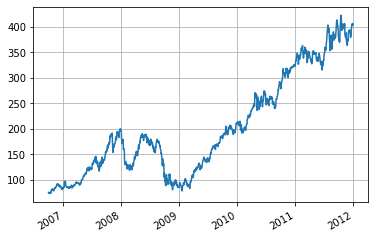

In [58]:

# Import Matplotlib's `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Plot the closing prices for `aapl`
aapl['Close'].plot(grid=True)

# Show the plot
plt.show()

## Common Financial Analysis

### Returns

In [59]:
# Assign `Adj Close` to `daily_close`
daily_close = aapl[['Adj Close']]

# Daily returns
daily_pct_c = daily_close.pct_change()

# Replace NA values with 0
daily_pct_c.fillna(0, inplace=True)

# Inspect daily returns
print(daily_pct_c)

# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)

# Print daily log returns
print(daily_log_returns)

            Adj Close
2006-10-02   0.000000
2006-10-03  -0.010419
2006-10-04   0.017549
2006-10-05  -0.007296
2006-10-06  -0.008152
...               ...
2011-12-23   0.011993
2011-12-27   0.007934
2011-12-28  -0.009569
2011-12-29   0.006159
2011-12-30  -0.000296

[1323 rows x 1 columns]
            Adj Close
2006-10-02        NaN
2006-10-03  -0.010474
2006-10-04   0.017396
2006-10-05  -0.007323
2006-10-06  -0.008185
...               ...
2011-12-23   0.011922
2011-12-27   0.007903
2011-12-28  -0.009615
2011-12-29   0.006140
2011-12-30  -0.000296

[1323 rows x 1 columns]


In [60]:
# Resample `aapl` to business months, take last observation as value 
monthly = aapl.resample('BM').apply(lambda x: x[-1])

# Calculate the monthly percentage change
monthly.pct_change()

# Resample `aapl` to quarters, take the mean as value per quarter
quarter = aapl.resample("4M").mean()

# Calculate the quarterly percentage change
quarter.pct_change()

,Open,High,Low,Close,Volume,Adj Close
2006-10-31,NaN,NaN,NaN,NaN,NaN,NaN
2007-02-28,0.125777,0.126451,0.121460,0.122860,0.369611,0.122860
2007-06-30,0.196030,0.195413,0.198331,0.197735,-0.080296,0.197735
2007-10-31,0.400961,0.404613,0.392010,0.400796,0.306882,0.400796
2008-02-29,0.127066,0.130711,0.117746,0.120394,0.172293,0.120394
2008-06-30,-0.003550,-0.004290,0.005927,0.003673,-0.209762,0.003673
2008-10-31,-0.114267,-0.108879,-0.124618,-0.118803,0.133219,-0.118803
2009-02-28,-0.363639,-0.363388,-0.359305,-0.360865,-0.161601,-0.360865
2009-06-30,0.312134,0.304359,0.324702,0.316588,-0.386935,0.316588
2009-10-31,0.421239,0.411193,0.425117,0.415901,-0.158270,0.415901


In [61]:
# Daily returns
daily_pct_c = daily_close / daily_close.shift(1) - 1

# Print `daily_pct_c`
print(daily_pct_c)

            Adj Close
2006-10-02        NaN
2006-10-03  -0.010419
2006-10-04   0.017549
2006-10-05  -0.007296
2006-10-06  -0.008152
...               ...
2011-12-23   0.011993
2011-12-27   0.007934
2011-12-28  -0.009569
2011-12-29   0.006159
2011-12-30  -0.000296

[1323 rows x 1 columns]


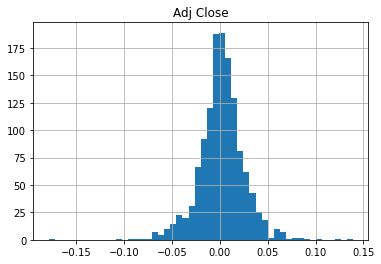

         Adj Close
count  1322.000000
mean      0.001566
std       0.023992
min      -0.179195
25%      -0.010672
50%       0.001677
75%       0.014306
max       0.139050


In [62]:

# Import matplotlib
import matplotlib.pyplot as plt

# Plot the distribution of `daily_pct_c`
daily_pct_c.hist(bins=50)

# Show the plot
plt.show()

# Pull up summary statistics
print(daily_pct_c.describe())

In [63]:
# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_c).cumprod()

# Print `cum_daily_return`
print(cum_daily_return)

            Adj Close
2006-10-02        NaN
2006-10-03   0.989581
2006-10-04   1.006946
2006-10-05   0.999599
2006-10-06   0.991451
...               ...
2011-12-23   5.387791
2011-12-27   5.430537
2011-12-28   5.378574
2011-12-29   5.411702
2011-12-30   5.410099

[1323 rows x 1 columns]


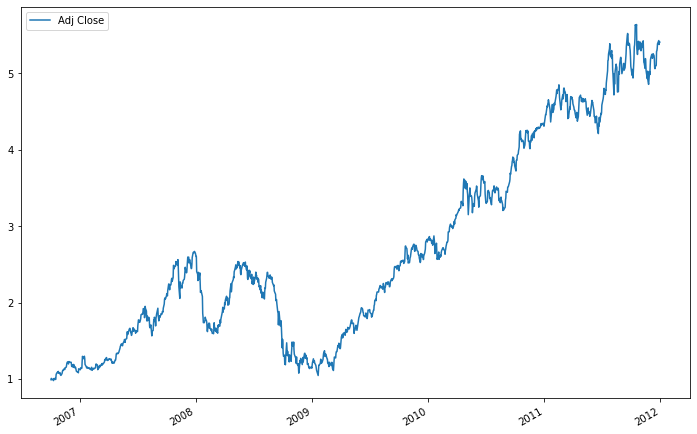

In [64]:

# Import matplotlib
import matplotlib.pyplot as plt 

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(12,8))

# Show the plot
plt.show()

In [65]:
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Print the `cum_monthly_return`
print(cum_monthly_return)

            Adj Close
2006-10-31   1.031710
2006-11-30   1.140058
2006-12-31   1.155110
2007-01-31   1.187303
2007-02-28   1.145176
...               ...
2011-08-31   5.032897
2011-09-30   5.243032
2011-10-31   5.306305
2011-11-30   5.140466
2011-12-31   5.248871

[63 rows x 1 columns]


In [67]:

from pandas_datareader import data as pdr
import yfinance

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1))
all_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
AAPL   2006-10-02  10.728572  10.838572  10.614285  10.694285   9.283074   
       2006-10-03  10.635715  10.707143  10.455714  10.582857   9.186352   
       2006-10-04  10.585714  10.780000  10.451428  10.768572   9.347562   
       2006-10-05  10.647142  10.880000  10.590000  10.690000   9.279355   
       2006-10-06  10.631429  10.720000  10.544286  10.602858   9.203714   

                      Volume  
Ticker Date                   
AAPL   2006-10-02  178159800  
       2006-10-03  197677200  
       2006-10-04  207270700  
       2006-10-05  170970800  
       2006-10-06  116739700

In [68]:
#all_data = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/all_stock_data.csv", index_col= [0,1], header=0, parse_dates=[1])

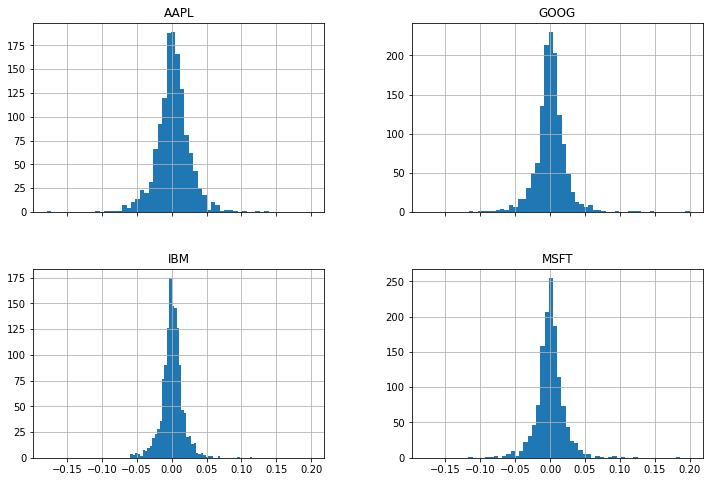

In [69]:
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

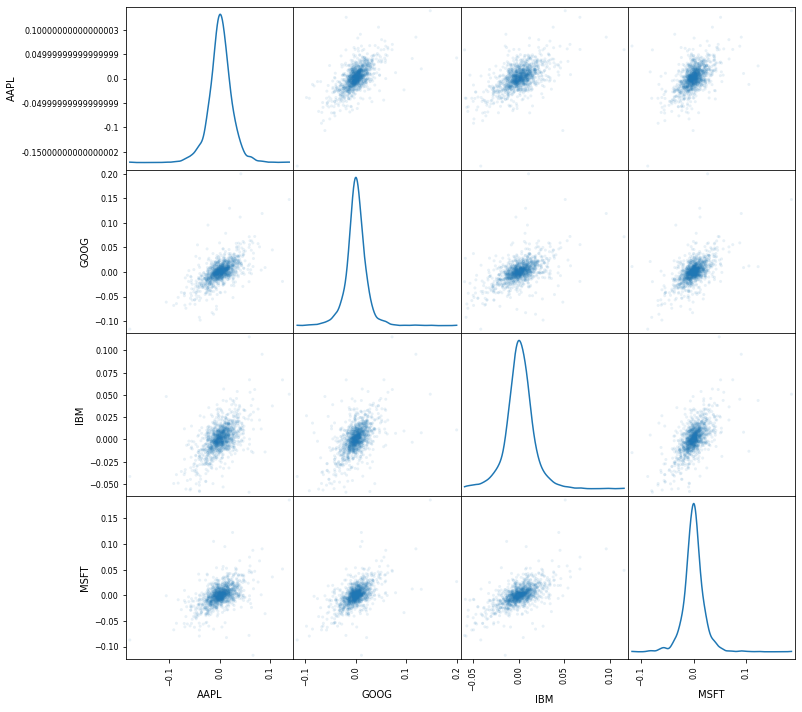

In [70]:
# Plot a scatter matrix with the `daily_pct_change` data 
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

# Show the plot
plt.show()

## Moving Windows

In [71]:
# Isolate the adjusted closing prices 
adj_close_px = aapl['Adj Close']

# Calculate the moving average
moving_avg = adj_close_px.rolling(window=40).mean()

# Inspect the result
moving_avg[-10:]

2011-12-16    55.529679
2011-12-19    55.491607
2011-12-20    55.456536
2011-12-21    55.451822
2011-12-22    55.444500
2011-12-23    55.439643
2011-12-27    55.445286
2011-12-28    55.437643
2011-12-29    55.468393
2011-12-30    55.495500
Name: Adj Close, dtype: float64

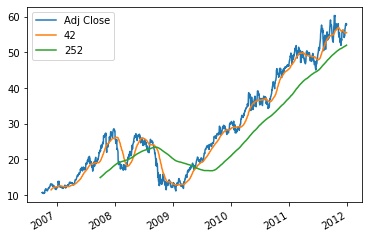

In [72]:
# Short moving window rolling mean
aapl['42'] = adj_close_px.rolling(window=40).mean()

# Long moving window rolling mean
aapl['252'] = adj_close_px.rolling(window=252).mean()

# Plot the adjusted closing price, the short and long windows of rolling means
aapl[['Adj Close', '42', '252']].plot()

plt.show()

## Volatility Calculation

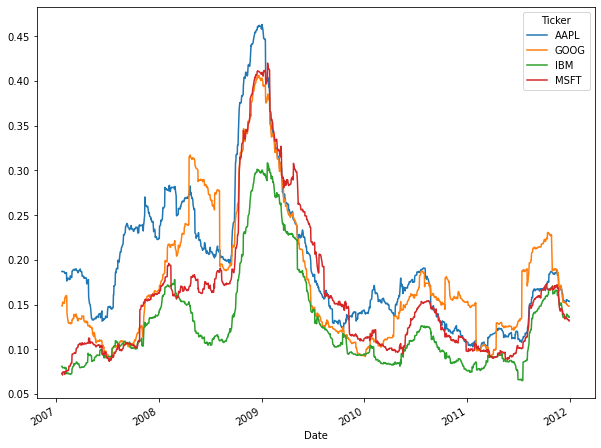

In [73]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

## Ordinary Least-Squares Regression (OLS)

In [74]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm
from pandas import tseries
from datetime import date, datetime

# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

# Isolate the AAPL returns 
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'AAPL']
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# Isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == 'MSFT']
msft_returns.index = msft_returns.index.droplevel('Ticker')

# Build up a new DataFrame with AAPL and MSFT returns
return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]
return_data.columns = ['AAPL', 'MSFT']

# Add a constant 
X = sm.add_constant(return_data['AAPL'])

# Construct the model
model = sm.OLS(return_data['MSFT'],X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSFT   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     515.5
Date:                Sun, 26 Apr 2020   Prob (F-statistic):           1.33e-96
Time:                        15:28:56   Log-Likelihood:                 3514.0
No. Observations:                1322   AIC:                            -7024.
Df Residuals:                    1320   BIC:                            -7014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.119      0.2

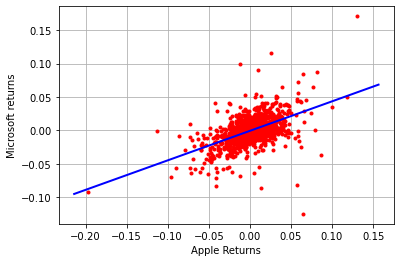

In [75]:
plt.plot(return_data['AAPL'], return_data['MSFT'], 'r.')

ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)

plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

plt.grid(True)
plt.axis('tight')
plt.xlabel('Apple Returns')
plt.ylabel('Microsoft returns')

plt.show()

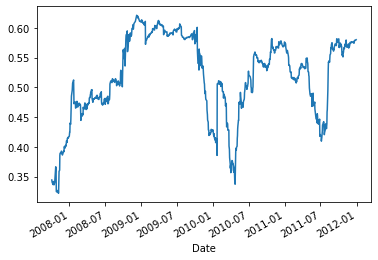

In [76]:

return_data['MSFT'].rolling(window=252).corr(return_data['AAPL']).plot()
plt.show()

## Building A Trading Strategy With Python

In [77]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()


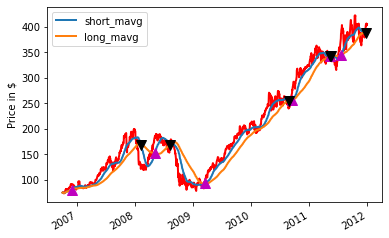

In [78]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

## Backtesting A Strategy

In [79]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

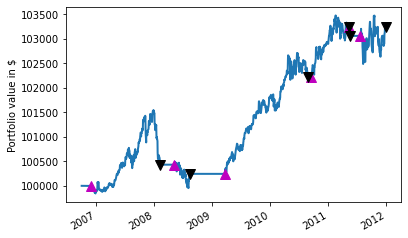

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against the equity curve
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

## Evaluating Moving Average Crossover Strategy

### Sharpe Ratio

In [81]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.7268769500133708


### Maximum Drawdown

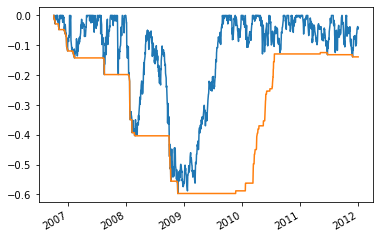

In [82]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = aapl['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

### Compound Annual Growth Rate (CAGR)

In [83]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print CAGR
print(cagr)

0.3823445620598196


# A Simple Time Series Analysis Of The S&P 500 Index

In this blog post we'll examine some common techniques used in time series analysis by applying them to a data set containing daily closing values for the S&P 500 stock market index from 1950 up to present day. The objective is to explore some of the basic ideas and concepts from time series analysis, and observe their effects when applied to a real world data set. Although it's not possible to actually predict changes in the index using these techniques, the ideas presented here could theoretically be used as part of a larger strategy involving many additional variables to conduct a regression or machine learning effort.

Time series analysis is a branch of statistics that involves reasoning about ordered sequences of related values in order to extract meaningful statistics and other characteristics of the data. It's used in a wide range of disciplines including econometrics, signal processing, weather forecasting, and basically any other field that involves time series data. These techniques are often used to develop models that can be used to attempt to forecast future values of a series, either on their own or in concert with other variables.

To get started, let's first download the data. I got the historial data set from Yahoo Finance, which includes a link to download the whole thing as a .csv file. Now we can load up the data set and take a look. I'll be using several popular Python libraries for the analysis, so all of the code is in Python.

In [85]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')

path = os.getcwd() + '\data\stock_data.csv'    
stock_data = pd.read_csv(r'C:\Users\gordon\OneDrive\CODE\4_Data\1_FullBuilds\sample\^GSPC.csv')
#stock_data['Date'] = stock_data['Date'].convert_objects(convert_dates='coerce')
#stock_data = stock_data.sort_index(by='Date')
stock_data = stock_data.set_index('Date')

stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-04,2814.370117,2816.879883,2767.659912,2792.810059,2792.810059,3919810000
2019-03-05,2794.409912,2796.439941,2782.969971,2789.649902,2789.649902,3585690000
2019-03-06,2790.270020,2790.270020,2768.689941,2771.449951,2771.449951,3786600000
2019-03-07,2766.530029,2767.250000,2739.090088,2748.929932,2748.929932,3904860000
2019-03-08,2730.790039,2744.129883,2722.270020,2743.070068,2743.070068,3423130000
...,...,...,...,...,...,...
2020-02-25,3238.939941,3246.989990,3118.770020,3128.209961,3128.209961,5591510000
2020-02-26,3139.899902,3182.510010,3108.989990,3116.389893,3116.389893,5478110000
2020-02-27,3062.540039,3097.070068,2977.389893,2978.760010,2978.760010,7058840000


The first obvious thing to note, aside from the two giant dips at the tail end corresponding to the market crashes in 2002 and 2008, is that the data is clearly non-stationary. This makes sense for market data as it tends to go up in the long run more than it goes down. This is a problem for time series analysis though as non-stationary data is hard to reason about. The first thing we can try is a first difference of the series. In other words, subtract the previous value t-1 from the current value t to get the difference d(t).

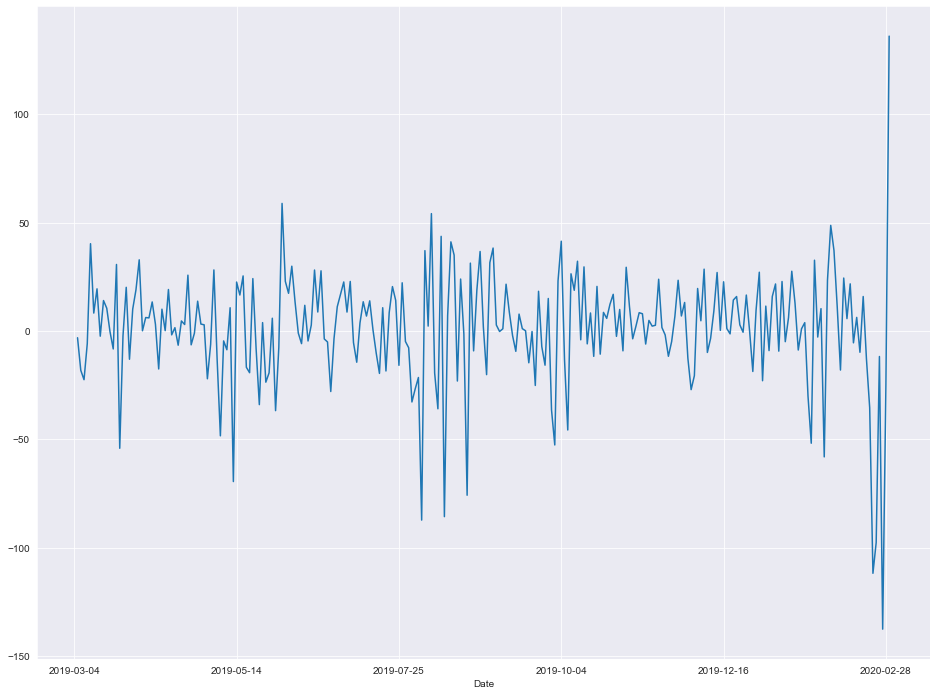

In [86]:
stock_data['First Difference'] = stock_data['Close'] - stock_data['Close'].shift()
stock_data['First Difference'].plot(figsize=(16, 12))

The data no longer appears to be trending up over time and is instead centered around 0. There's another problem though. Look at the variance. It's very small early on and steadily increases over time. This is a sign that the data is not only non-stationary but also exponentially increasing. The magnitude of the day-to-day variations at present day completely dwarf the magnitude of the changes in 1950. To deal with this, we'll apply a log transform to the original series.

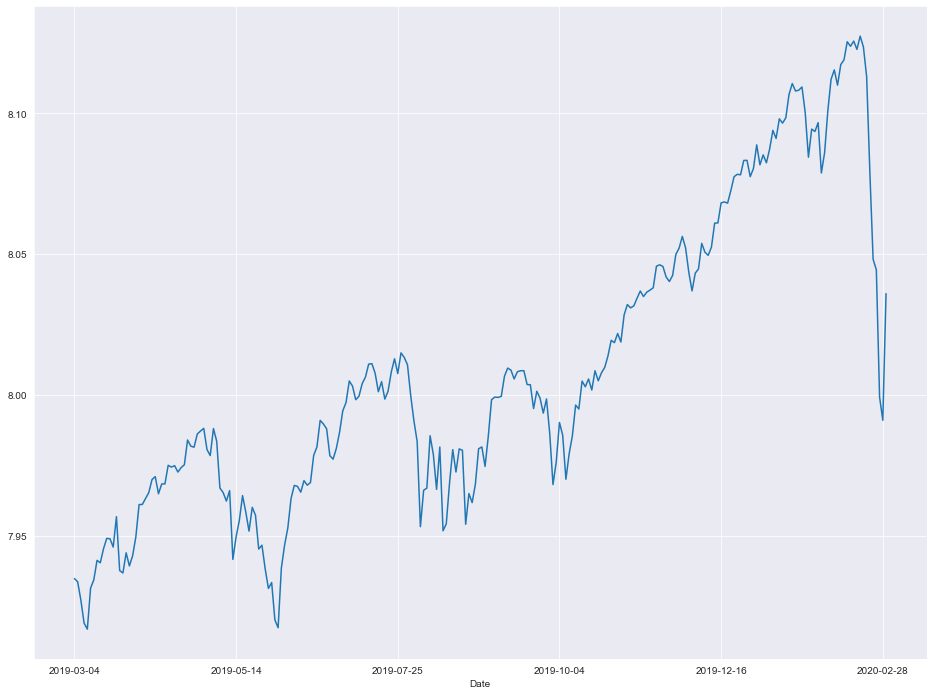

In [87]:
stock_data['Natural Log'] = stock_data['Close'].apply(lambda x: np.log(x))
stock_data['Natural Log'].plot(figsize=(16, 12))

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

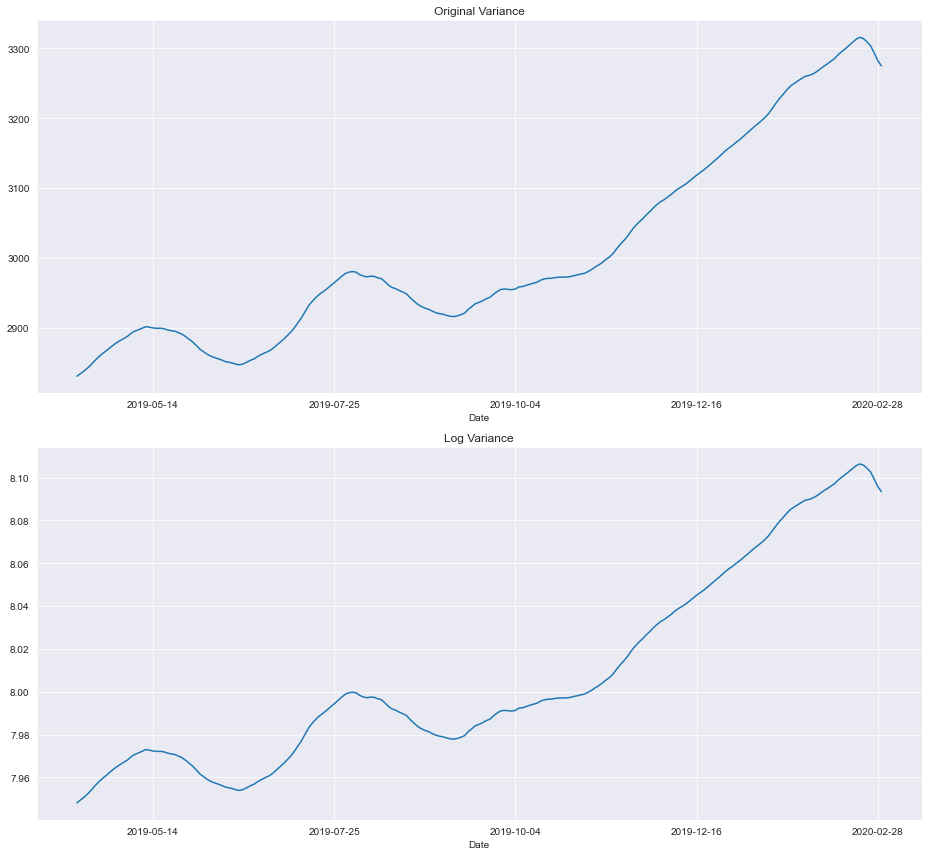

In [88]:
stock_data['Original Variance'] = stock_data['Close'].rolling(30).mean()
stock_data['Log Variance'] = stock_data['Natural Log'].rolling(30).mean()

 #= pd.rolling_mean(stock_data['Close'], 30, min_periods=None, freq=None, center=True)
 #= pd.rolling_mean(stock_data['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
stock_data['Original Variance'].plot(ax=ax[0], title='Original Variance')
stock_data['Log Variance'].plot(ax=ax[1], title='Log Variance')
fig.tight_layout()

#ts_log.rolling(30).mean()

Observe that in the top graph, we can't even see any of the variations until the late 80s. In the bottom graph however it's a different story, changes in the value are clearly visible throughout the entire data set. From this view, it's clear that our transformation has made the variance relatively constant.

Now we can see the earlier variations in the data set quite a bit better than before. We still need to take the first difference though so let's calculate that from the logged series.

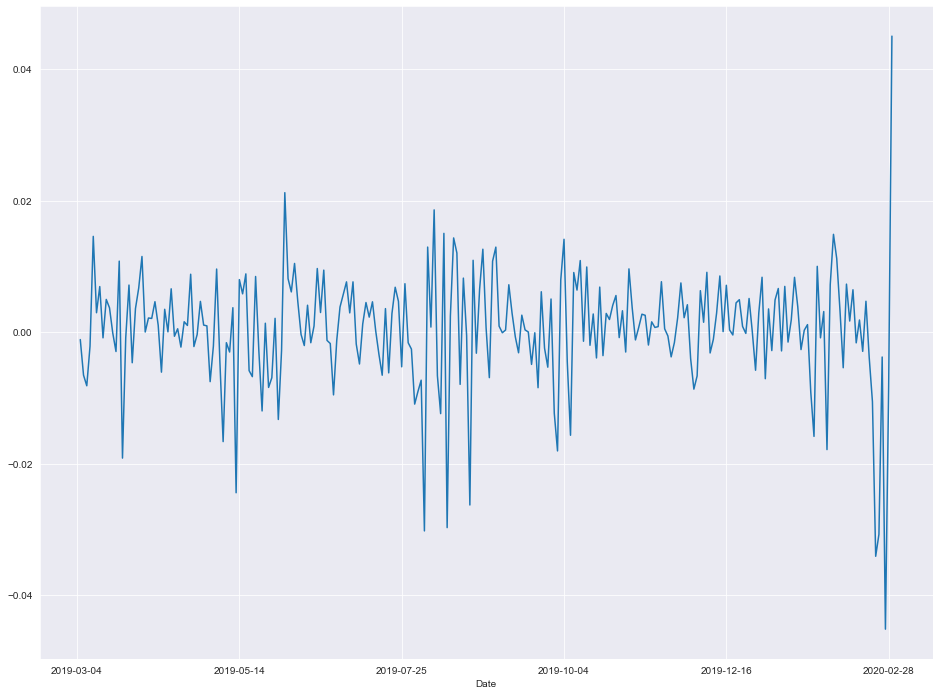

In [89]:
stock_data['Logged First Difference'] = stock_data['Natural Log'] - stock_data['Natural Log'].shift()
stock_data['Logged First Difference'].plot(figsize=(16, 12))

Much better! We now have a stationary time series model of daily changes to the S&P 500 index. Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

One interesting visual way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable vs. the lagged variable and see where the distribution lies. We can do this with a joint plot using the seaborn package.

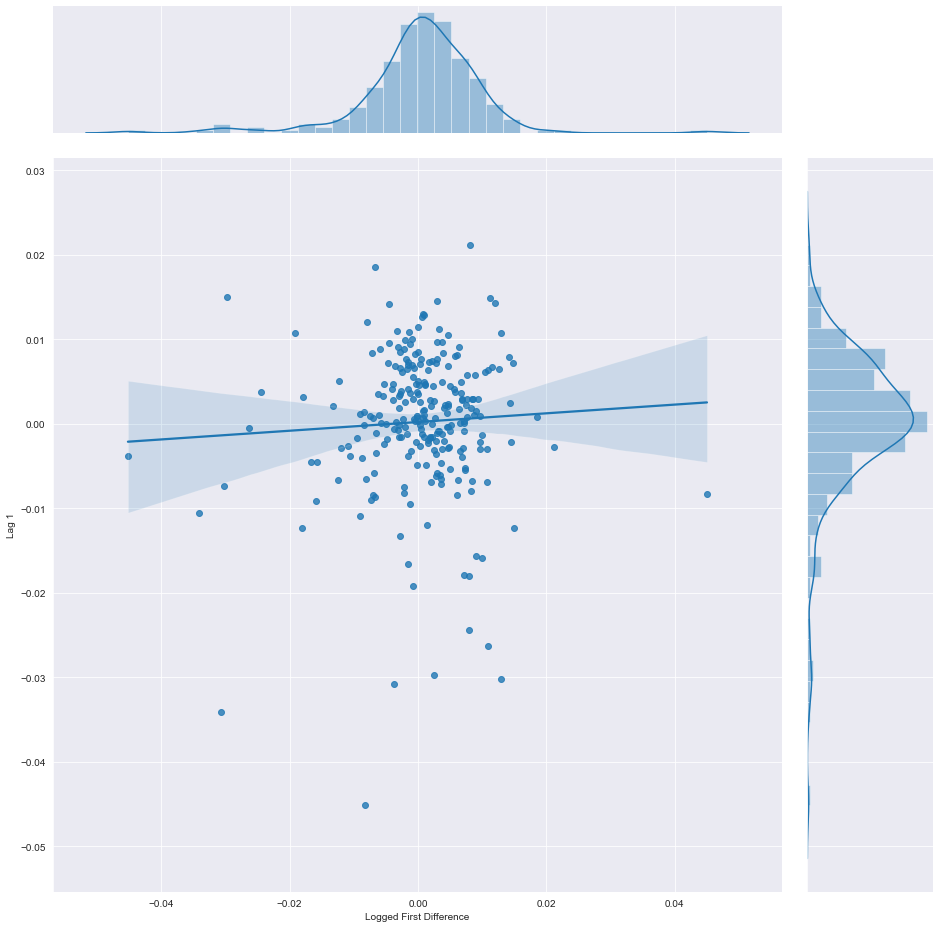

In [90]:
stock_data['Lag 1'] = stock_data['Logged First Difference'].shift()
stock_data['Lag 2'] = stock_data['Logged First Difference'].shift(2)
stock_data['Lag 5'] = stock_data['Logged First Difference'].shift(5)
stock_data['Lag 30'] = stock_data['Logged First Difference'].shift(30)

sb.jointplot('Logged First Difference', 'Lag 1', stock_data, kind='reg', height=13)


Notice how tightly packed the mass is around 0. It also appears to be pretty evenly distributed - the marginal distributions on both axes are roughly normal. This seems to indicate that knowing the index value one day doesn't tell us much about what it will do the next day.

It probably comes as no surprise that there's very little correlation between the change in value from one day to the next. Although I didn't plot them out here, the other lagged variables that we created above show similar results. There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually. Fortunately there is a class of functions that can systematically do this for us.

In [91]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(stock_data['Logged First Difference'].iloc[1:])
lag_partial_correlations = pacf(stock_data['Logged First Difference'].iloc[1:])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



The auto-correlation function computes the correlation between a variable and itself at each lag step up to some limit (in this case 40). The partial auto-correlation function computes the correlation at each lag step that is NOT already explained by previous, lower-order lag steps. We can plot the results to see if there are any significant correlations.

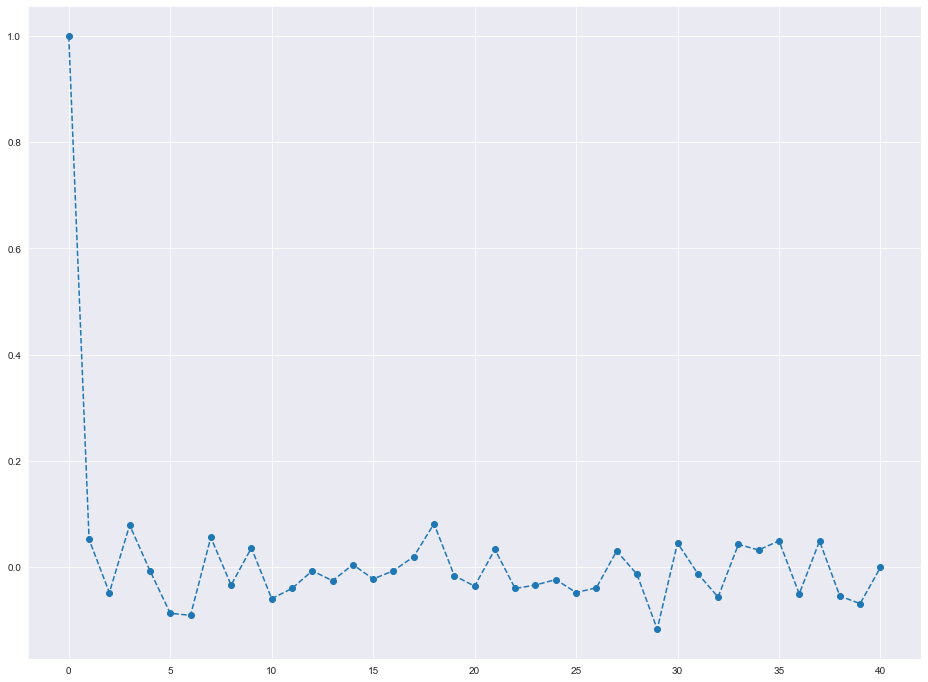

In [92]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(lag_correlations, marker='o', linestyle='--')

The auto-correlation and partial-autocorrelation results are very close to each other (I only plotted the auto-correlation results above). What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. In order words, the series is a random walk.

Another interesting technique we can try is a decomposition. This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.

<Figure size 432x288 with 0 Axes>

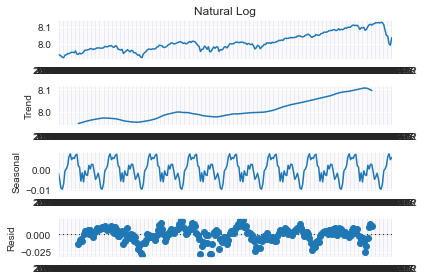

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Natural Log'], model='additive', period=30)
fig = plt.figure()
fig = decomposition.plot()

Since we don't see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal pattern though it can be very useful. The folling instance, for example, is a sample from the statsmodels documentation showing CO2 emissions data over time.

<Figure size 432x288 with 0 Axes>

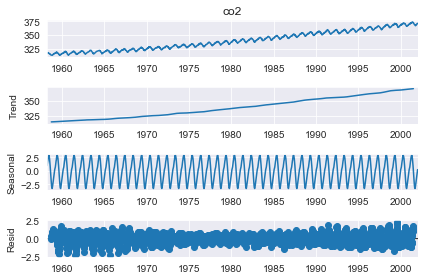

In [94]:
co2_data = sm.datasets.co2.load_pandas().data
co2_data.co2.interpolate(inplace=True)
result = sm.tsa.seasonal_decompose(co2_data.co2)
fig = plt.figure()
fig = result.plot()

The decomposition is much more useful in this case. There are three clearly distinct components to the time series - a trend line, a seasonal adjustment, and residual values. Each of these would need to be accounted for and modeled appropriately.

Going back to our stock data, we're already observed that it's a random walk and that our lagged variables don't seem to have much impact, but we can still try fitting some ARIMA models and see what we get. Let's start with a simple moving average model.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



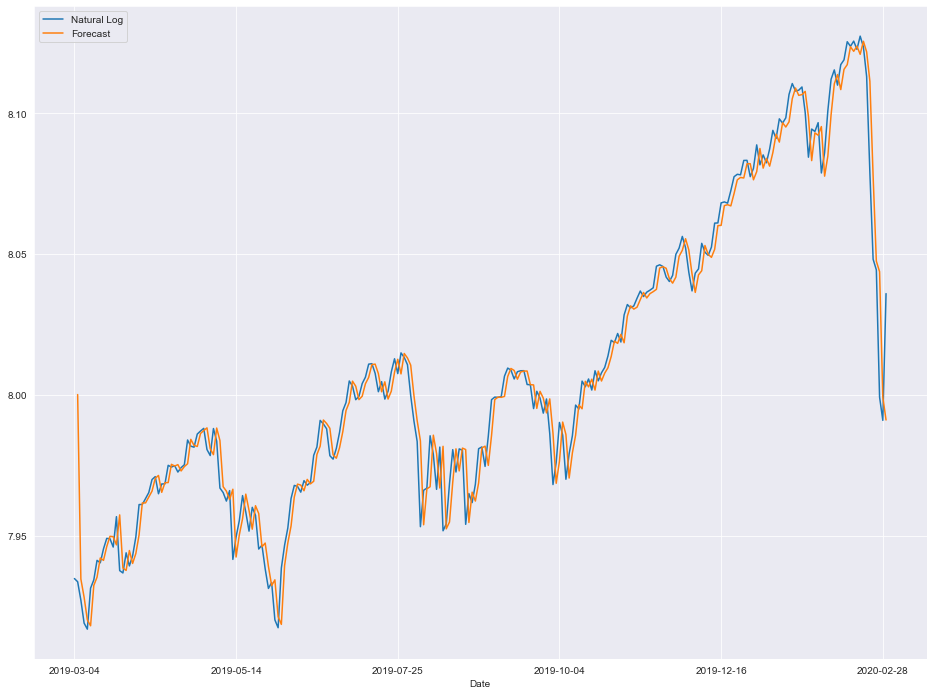

In [95]:
model = sm.tsa.ARIMA(stock_data['Natural Log'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Natural Log', 'Forecast']].plot(figsize=(16, 12))

So at first glance it seems like this model is doing pretty well. But although it appears like the forecasts are really close (the lines are almost indistinguishable after all), remember that we used the un-differenced series! The index only fluctuates a small percentage day-to-day relative to the total absolute value. What we really want is to predict the first difference, or the day-to-day moves. We can either re-run the model using the differenced series, or add an "I" term to the ARIMA model (resulting in a (1, 1, 0) model) which should accomplish the same thing. Let's try using the differenced series.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



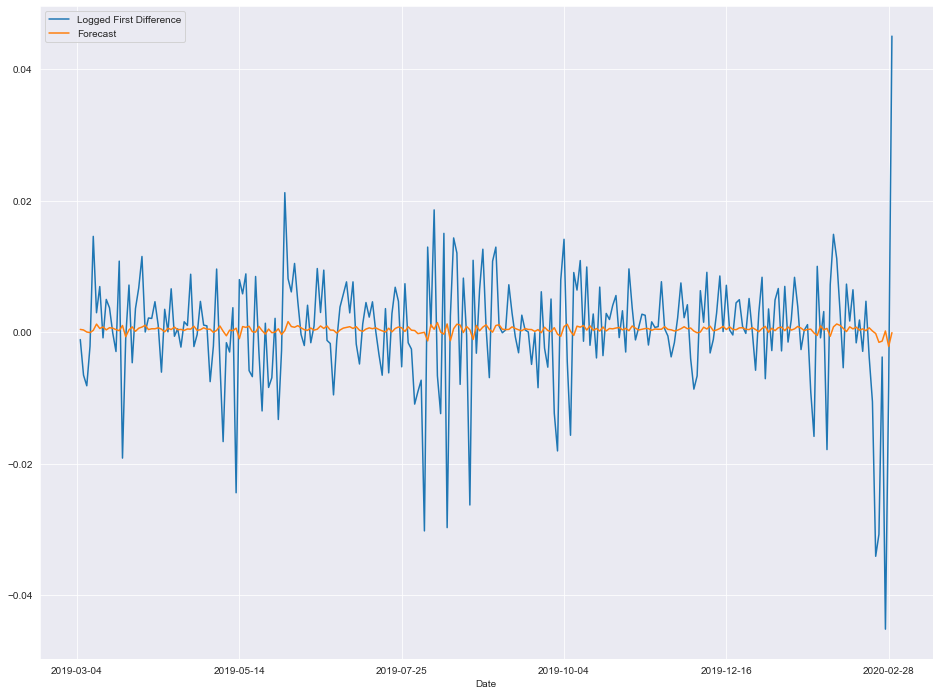

In [96]:
model = sm.tsa.ARIMA(stock_data['Logged First Difference'].iloc[1:], order=(1, 0, 0))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))

It's a little hard to tell, but it appears like our forecasted changes are generally much smaller than the actual changes. It might be worth taking a closer look at a subset of the data to see what's really going on.

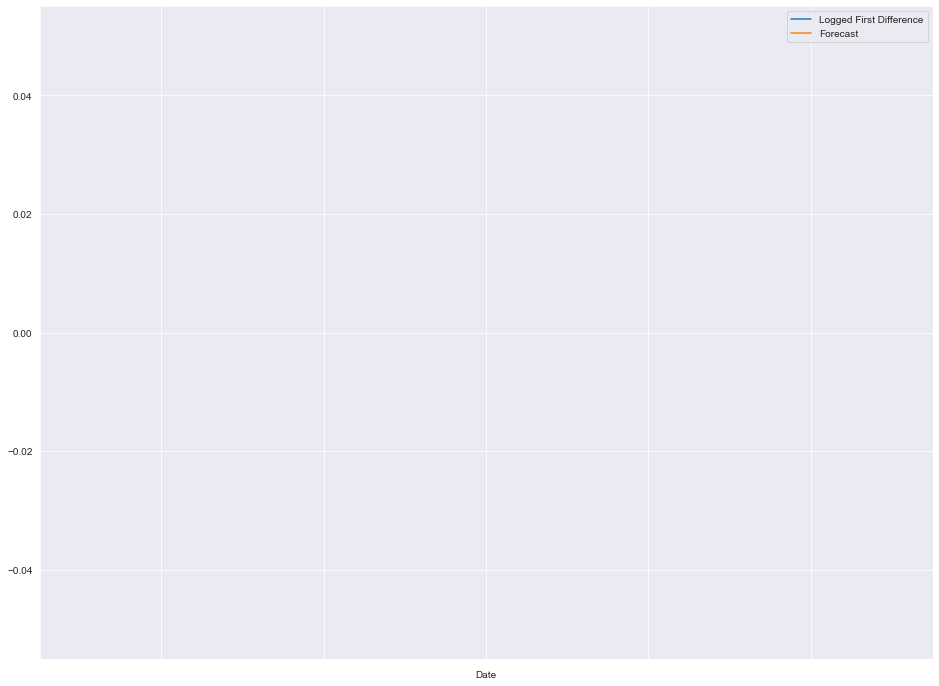

In [97]:
stock_data[['Logged First Difference', 'Forecast']].iloc[1200:1600, :].plot(figsize=(16, 12))


So now it's pretty obvious that the forecast is way off. We're predicting tiny little variations relative to what is actually happening day-to-day. Again, this is more of less expected with a simple moving average model of a random walk time series. There's not enough information from the previous days to accurately forcast what's going to happen the next day.

A moving average model doesn't appear to do so well. What about an exponential smoothing model? Exponential smoothing spreads out the impact of previous values using an exponential weighting, so things that happened more recently are more impactful than things that happened a long time ago. Maybe this "smarter" form of averaging will be more accurate?

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



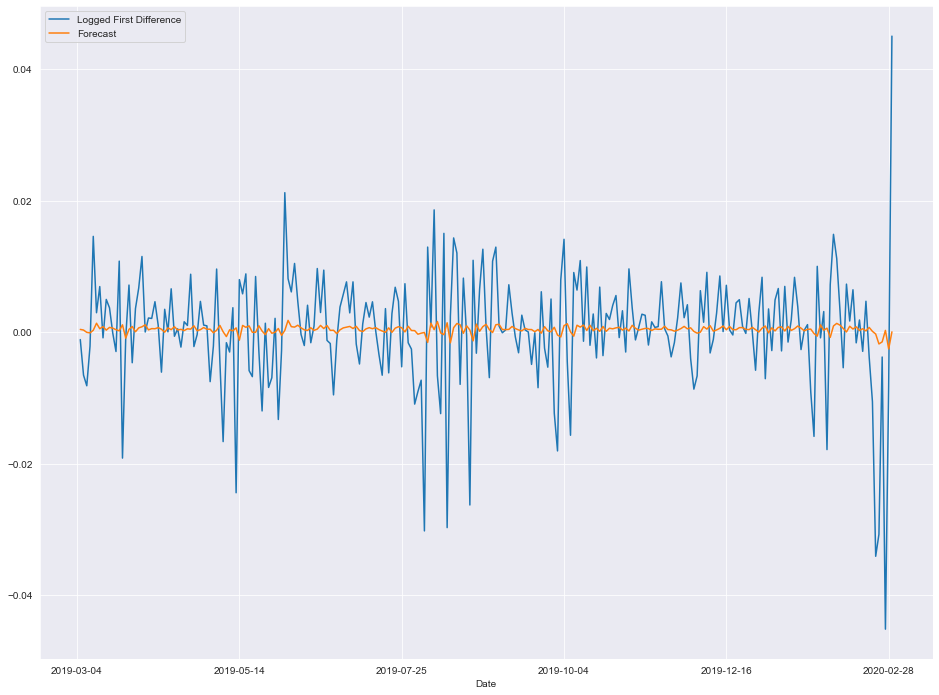

In [98]:
model = sm.tsa.ARIMA(stock_data['Logged First Difference'].iloc[1:], order=(0, 0, 1))
results = model.fit(disp=-1)
stock_data['Forecast'] = results.fittedvalues
stock_data[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))

You can probably guess the answer...if predicting the stock market were this easy, everyone would be doing it! As I mentioned at the top, the point of this analysis wasn't to claim that you can predict the market with these techniques, but rather to demonstrate the types of the analysis one might use when breaking down time series data. Time series analysis is a very rich field with lots more technical analysis than what I went into here (much of which I'm still learning). If you're interested in doing a deeper dive, I recommend these notes from a professor at Duke. A lot of what I learned about the field I picked up from reading online resources like this one. Finally, the original source code from this post is hosted on GitHub here, along with a variety of other notebooks. Feel free to check it out!